## Логистическая регрессия

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import math


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    def __sigma(self, t):
        t = np.clip(t, -10, 10)
        return 1 / (1 + np.exp(-t))

    def __l1_penalty(self):
        return 1/self.C * np.sign(self.theta)

    def __l2_penalty(self):
        return 1/self.C * self.theta

    def __none_penalty(self):
        return 0
    
    def __init__(self, C=1, alpha=1, max_epoch=10, penalty='none'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.theta = None
        self.chunk_size = 5     # Количество элементов в чанке (от 1 до общего числа точек)
        self.errors = None
        if penalty == 'l1':
            self.penalty = self.__l1_penalty 
        elif penalty == 'l2':
            self.penalty = self.__l2_penalty
        else:
            self.penalty = self.__none_penalty

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        import time

        np.random.seed(int(time.time()))
        
        n, m = X.shape   # n - число строк, m - столбцов        
        
        sigma = self.__sigma
        chunk_size = self.chunk_size
        errors = np.ones(self.max_epoch)
        
        X_b = np.c_[X, np.ones(n)]
        self.theta = np.random.randn(m + 1, 1)
        Y = np.vstack(y)
               
        for epoch in range(self.max_epoch):

            lst = list(range(n))
            np.random.shuffle(lst)
            chunks = [lst[i : i+chunk_size] for i in range(0, n, chunk_size)]

            for chunk in chunks:
                xi = X_b[chunk]
                yi = Y[chunk]
                gradients = xi.T.dot(sigma(xi.dot(self.theta)) - yi)
                self.theta = self.theta - self.alpha * gradients + self.penalty()
                
            p = sigma(X_b.dot(self.theta))
            
            errors[epoch] = 1 / n * np.sum(-(Y * np.log(p) + (1 - Y)*np.log(1 - p)))
            
        self.errors = errors            
        
        return self

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''

        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat_proba = self.predict_proba(X)
        y_hat = np.where(y_hat_proba[0] >= 0.5, 0, 1)
        
        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        
        if self.theta is None:
            raise Exception("Model is not fitted yet. Use method 'fit'")
        
        n, m = X.shape
        X_b = np.c_[X, np.ones(n)]

        y1 = self.__sigma(X_b.dot(self.theta))
        y0 = 1 - y1
        y_hat_proba = np.c_[y0, y1]
        
        return y_hat_proba


## Проверка на синтетических данных

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

theta =  [[ 0.86287724]
 [-1.09072484]
 [-4.21822612]]


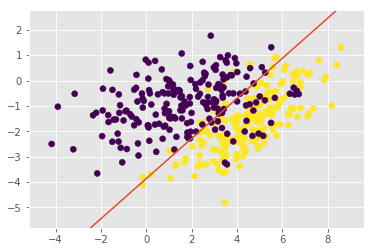

In [3]:
max_epoch = 20

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

model = MySGDClassifier(alpha=.01, max_epoch=max_epoch, penalty = 'none', C = 100)
model.fit(X, y)

print("theta = ", model.theta)

t0 = model.theta.item(0)
t1 = model.theta.item(1)
t2 = model.theta.item(2)

x_ = np.array([x_min, x_max])
y_ = -(x_ * t0 + t2) / t1

ax.plot(x_, y_)
ax.set_xlim(x_min - 1, x_max + 1)
ax.set_ylim(y_min - 1, y_max + 1)
plt.show()


In [4]:
x_check = np.array([[-2,-1], # class 0
                    [4,-5]]) # class 1
model.predict_proba(x_check)

array([[0.99225748, 0.00774252],
       [0.009131  , 0.990869  ]])

In [5]:
model.predict(x_check)

array([1, 0])

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

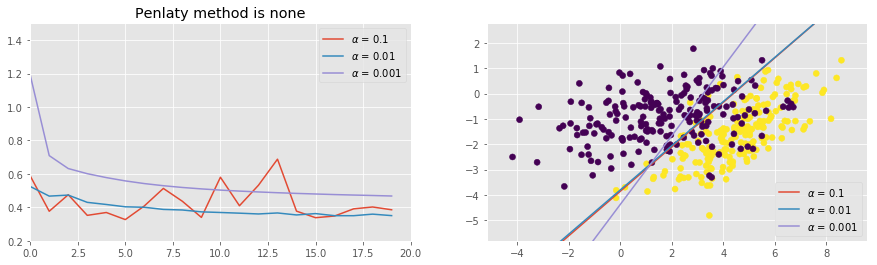

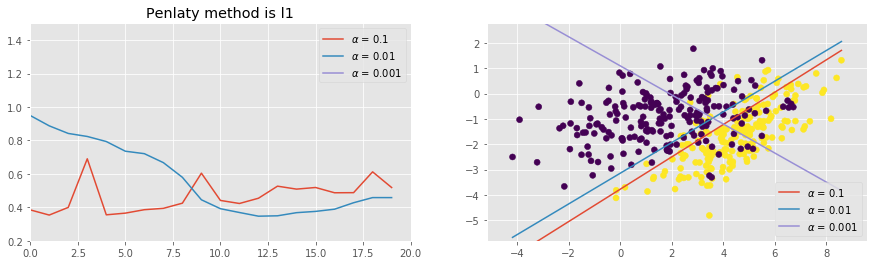

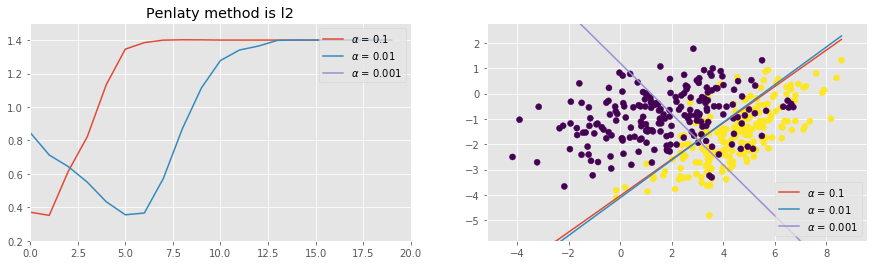

In [6]:
alphas = [0.1, 0.01, 0.001]
penalties = ['none', 'l1', 'l2']
penalty_coef = 100

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

for penalty in penalties:
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))    
    ax[1].scatter(X[:,0], X[:,1], c=y)
   
    ax[0].set_xlim(0, max_epoch)
    ax[0].set_ylim(0.2, 1.5)
    ax[0].set_title('Penlaty method is {}'.format(penalty))
    for alpha in alphas:
        model = MySGDClassifier(alpha=alpha, max_epoch=max_epoch, penalty = penalty, C = penalty_coef)
        model.fit(X, y)
        ax[0].plot(range(max_epoch), model.errors, label=r'$\alpha$ = {}'.format(alpha))
        
        t0 = model.theta.item(0)
        t1 = model.theta.item(1)
        t2 = model.theta.item(2)

        x_ = np.array([x_min, x_max])
        y_ = -(x_ * t0 + t2) / t1
        ax[1].plot(x_, y_, label=r'$\alpha$ = {}'.format(alpha))
        ax[1].set_xlim(x_min - 1, x_max + 1)
        ax[1].set_ylim(y_min - 1, y_max + 1)

        
    ax[0].legend(loc='upper right')    
    ax[1].legend(loc='lower right')    
# ax.title = ''
plt.show()